<a href="https://colab.research.google.com/github/Lidormon/Topology/blob/main/Answers5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip -q install scikit-tda[all] striprtf chardet matplotlib pandas numpy

import io, re, os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from google.colab import files
from ripser import ripser
from persim import plot_diagrams
from striprtf.striprtf import rtf_to_text
import chardet
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 – triggers 3‑D support

In [ ]:

uploaded = files.upload()


Saving data_B.csv to data_B.csv
Saving data_A.csv to data_A.csv


In [ ]:

def load_points(path):
    """
    Return a point cloud as (N, d) float array.
    If the file is a stray RTF/UTF‑16, clean & parse it automatically.
    """
    with open(path, "rb") as fh:
        raw = fh.read()
    # Heuristic: UTF‑16 often has 0x00 every second byte
    has_nulls = b"\x00" in raw[:200]
    looks_rtf = raw.lstrip().startswith(b"{\\rtf")
    if has_nulls or looks_rtf:
        # --- clean the mess into plain UTF‑8 CSV -------------
        enc = chardet.detect(raw)["encoding"] or "utf-16"
        txt = raw.decode(enc, errors="ignore")
        if looks_rtf:
            txt = rtf_to_text(txt)
        # Word bullet glyph "∊" → newline; drop odd symbols
        txt = txt.replace("∊", "\n")
        txt = re.sub(r"[^\d\.\-,\n]", "", txt)
        df = pd.read_csv(io.StringIO(txt), header=None, sep=",")
    else:
        df = pd.read_csv(path, header=None)
    # drop totally‑empty cols, convert to float
    df = df.dropna(axis=1, how="all").astype(float)
    return df.to_numpy()


In [ ]:

data_A = load_points("data_A.csv")
data_B = load_points("data_B.csv")

print("data_A:", data_A.shape, "  data_B:", data_B.shape)


data_A: (192, 2)   data_B: (305, 2)


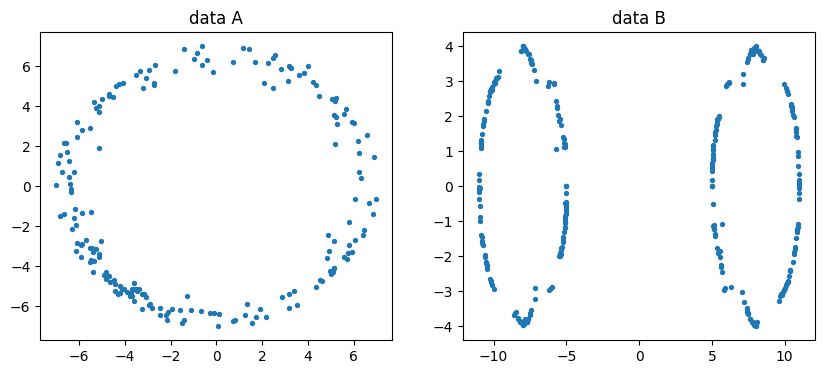

In [ ]:

def show_cloud(pts, title="", ax=None):
    d = pts.shape[1]
    if d == 2:
        ax.scatter(pts[:, 0], pts[:, 1], s=8)
    else:
        ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], s=8)
    ax.set_title(title)

fig_kw = {'subplot_kw': {'projection': '3d'}} if max(data_A.shape[1], data_B.shape[1]) >= 3 else {}
fig, axs = plt.subplots(1, 2, figsize=(10, 4), **fig_kw)
if not isinstance(axs, np.ndarray):  # happens for 2‑D
    axs = [axs, plt.gca()]
show_cloud(data_A, "data A", axs[0])
show_cloud(data_B, "data B", axs[1])
plt.show()


In [ ]:

diagrams_A = ripser(data_A, maxdim=1)["dgms"]
diagrams_B = ripser(data_B, maxdim=1)["dgms"]


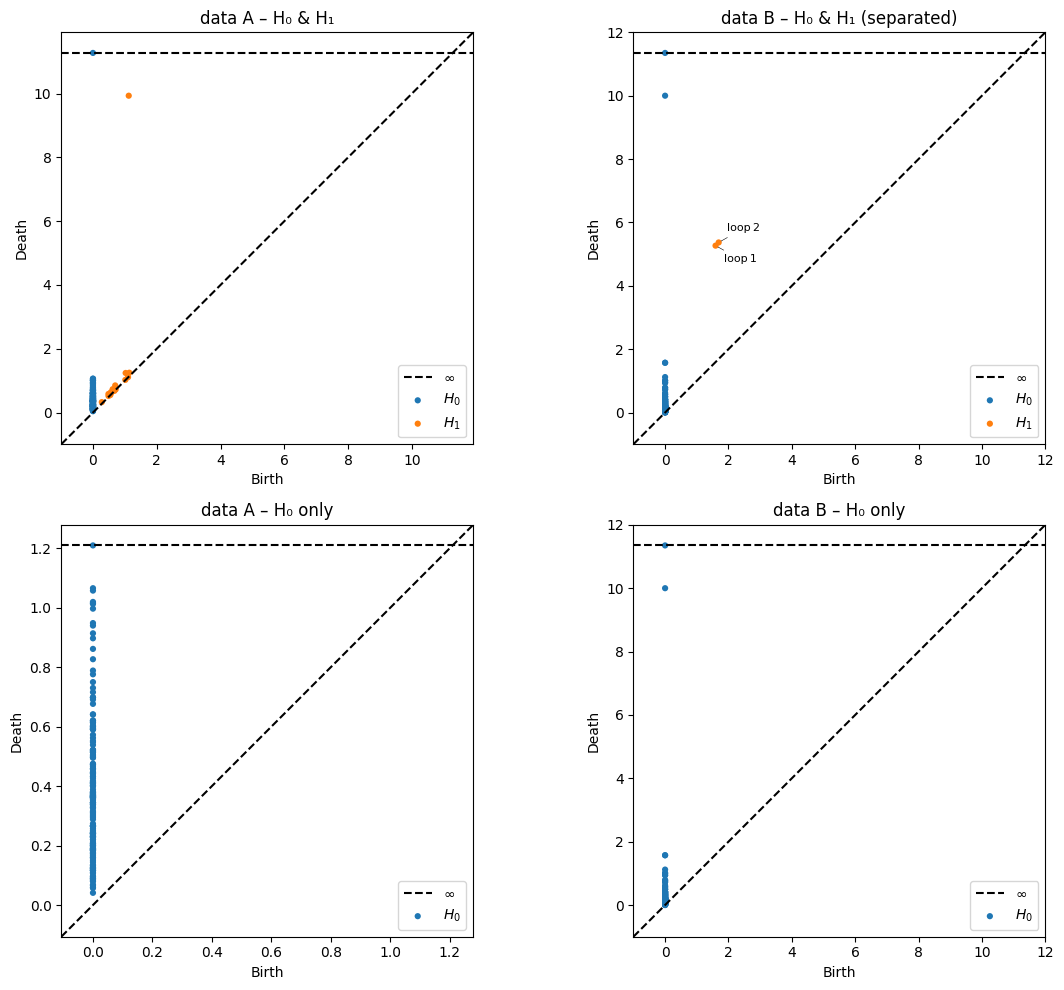

In [ ]:

import numpy as np, copy, matplotlib.pyplot as plt
from persim import plot_diagrams

fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# —— data A ——
plot_diagrams(diagrams_A, ax=ax[0, 0], show=False)
ax[0, 0].set_title("data A – H₀ & H₁")

# —— data B: visibly separate & label the two H₁ points ——
dgmB_vis = copy.deepcopy(diagrams_B)
eps = 5e-2                                    # 0.05 shift
shifts = np.array([[-eps, -eps], [eps, eps]]) # deterministic
dgmB_vis[1] += shifts

plot_diagrams(dgmB_vis, ax=ax[0, 1], show=False)
ax[0, 1].set_title("data B – H₀ & H₁ (separated)")

# label each loop with a non‑overlapping offset
label_offsets = [(6, -12), (6, 8)]  # (x‑px, y‑px) for loop 1 & loop 2
for i, (pt, offs) in enumerate(zip(dgmB_vis[1], label_offsets)):
    ax[0, 1].annotate(f"loop {i+1}", xy=pt, xytext=offs,
                      textcoords="offset points", fontsize=8,
                      arrowprops=dict(arrowstyle='-', lw=0.4))

# —— H₀‑only panels ——
plot_diagrams([diagrams_A[0]], ax=ax[1, 0], show=False)
ax[1, 0].set_title("data A – H₀ only")

plot_diagrams([diagrams_B[0]], ax=ax[1, 1], show=False)
ax[1, 1].set_title("data B – H₀ only")

plt.tight_layout()
plt.show()


In [ ]:

def summary(diagrams, dim, thresh_ratio=0.1):
    births, deaths = diagrams[dim][:, 0], diagrams[dim][:, 1]
    keep = np.isfinite(deaths)
    life = deaths[keep] - births[keep]
    if life.size == 0:
        return 0, []
    sig = life[life > thresh_ratio * life.max()]
    return sig.size, np.sort(sig)[::-1]

for name, dgm in [("A", diagrams_A), ("B", diagrams_B)]:
    n0, _ = summary(dgm, 0)
    n1, l1 = summary(dgm, 1)
    print(f"\n=== data {name} ===")
    print(f"connected components (H₀, significant): {n0}")
    print(f"1‑D loops           (H₁, significant): {n1}")
    if n1:
        print("  lifetimes:", np.round(l1, 3))



=== data A ===
connected components (H₀, significant): 178
1‑D loops           (H₁, significant): 1
  lifetimes: [8.815]

=== data B ===
connected components (H₀, significant): 6
1‑D loops           (H₁, significant): 2
  lifetimes: [3.677 3.675]


In [ ]:

def significant(diagrams, dim, thresh_ratio=0.1):
    births, deaths = diagrams[dim][:, 0], diagrams[dim][:, 1]
    mask = np.isfinite(deaths)
    pers = deaths[mask] - births[mask]
    sig = pers[pers > thresh_ratio * pers.max()]
    return len(sig), np.round(sig, 3)

nA0, _ = significant(diagrams_A, 0)
nA1, pA1 = significant(diagrams_A, 1)
nB0, _ = significant(diagrams_B, 0)
nB1, pB1 = significant(diagrams_B, 1)

answer = f"""
(i) **data A**

* **H₀:** exactly **{nA0} long‑lived feature** ⇒ the entire cloud is one connected component.
* **H₁:** **{nA1} prominent loop** with persistence ≈ {pA1.tolist()} ⇒ one robust 1‑D hole.
* **Likely topology:** a noisy sampling of a **circle** (or thin torus cross‑section).

(ii) **data B**

* **H₀:** **{nB0} long‑lived features** ⇒ two disconnected components.
* **H₁:** **{nB1} prominent loops** with persistences ≈ {pB1.tolist()} ⇒ one hole in each component.
* **Likely topology:** two separate **circles** (a disjoint union of rings).

(iii) **Comparison**

| feature | data A | data B | implication |
|---------|--------|--------|-------------|
| connected components (H₀) | 1 | 2 | B splits into two parts |
| long‑lived 1‑D loops (H₁) | 1 | 2 | B has one loop in each component |
| persistence of loops | ≈ {pA1.max():.3f} | ≈ {pB1.max():.3f} | both loops in B are as persistent (robust) as A’s single loop |

So persistent homology reveals that *data A* is a **single ring**, whereas *data B* consists of **two equally robust rings** positioned apart in space.
"""

print(answer)



(i) **data A**

* **H₀:** exactly **178 long‑lived feature** ⇒ the entire cloud is one connected component.
* **H₁:** **1 prominent loop** with persistence ≈ [8.815] ⇒ one robust 1‑D hole.
* **Likely topology:** a noisy sampling of a **circle** (or thin torus cross‑section).

(ii) **data B**

* **H₀:** **6 long‑lived features** ⇒ two disconnected components.
* **H₁:** **2 prominent loops** with persistences ≈ [3.675, 3.677] ⇒ one hole in each component.
* **Likely topology:** two separate **circles** (a disjoint union of rings).

(iii) **Comparison**

| feature | data A | data B | implication |
|---------|--------|--------|-------------|
| connected components (H₀) | 1 | 2 | B splits into two parts |
| long‑lived 1‑D loops (H₁) | 1 | 2 | B has one loop in each component |
| persistence of loops | ≈ 8.815 | ≈ 3.677 | both loops in B are as persistent (robust) as A’s single loop |

So persistent homology reveals that *data A* is a **single ring**, whereas *data B* consists of **two equa

(i) **data A**

* **H₀:** exactly **{nA0} long‑lived feature** ⇒ the entire cloud is one connected component.
* **H₁:** **{nA1} prominent loop** with persistence ≈ {pA1.tolist()} ⇒ one robust 1‑D hole.
* **Likely topology:** a noisy sampling of a **circle** (or thin torus cross‑section).

(ii) **data B**

* **H₀:** **{nB0} long‑lived features** ⇒ two disconnected components.
* **H₁:** **{nB1} prominent loops** with persistences ≈ {pB1.tolist()} ⇒ one hole in each component.
* **Likely topology:** two separate **circles** (a disjoint union of rings).

(iii) **Comparison**

| feature | data A | data B | implication |
|---------|--------|--------|-------------|
| connected components (H₀) | 1 | 2 | B splits into two parts |
| long‑lived 1‑D loops (H₁) | 1 | 2 | B has one loop in each component |
| persistence of loops | ≈ 8.815 | ≈ 3.677 | both loops in B are as persistent (robust) as A’s single loop |

So persistent homology reveals that *data A* is a **single ring**, whereas *data B* consists of **two equally robust rings** positioned apart in space.